In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [3]:
strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 2

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [5]:
df = pd.read_csv('train_set.csv')
df.head()

,CELEX_ID,Text,Directory code,Citations
0,32012D0012(01),14.7.2012 EN Official Journal of the European ...,10-30,"['OJL341,22.12.2011,p.65', 'OJL331,14.12.2011,..."
1,52018DP0022,21.12.2018 EN Official Journal of the European...,01-40,"['OJL353,31.12.2008,p.1', 'OJL208,2.8.2016,p.1..."
2,32020D1214(02),14.12.2020 EN Official Journal of the European...,01-40,"['OJC315I,23.9.2020,p.5', 'OJL141,27.5.2011,p.1']"
3,32010D1007(01),7.10.2010 EN Official Journal of the European ...,13-20,"['OJL8,12.1.2001,p.1', 'OJL196,24.7.2008,p.1',..."
4,32019D1742,21.10.2019 EN Official Journal of the European...,07-40,"['OJL128,9.5.2013,p.1', 'OJL96,31.3.2004,p.1',..."


In [6]:
X_data = df[['Text']].to_numpy().reshape(-1)
y_data = df[['Directory code']].to_numpy().reshape(-1)

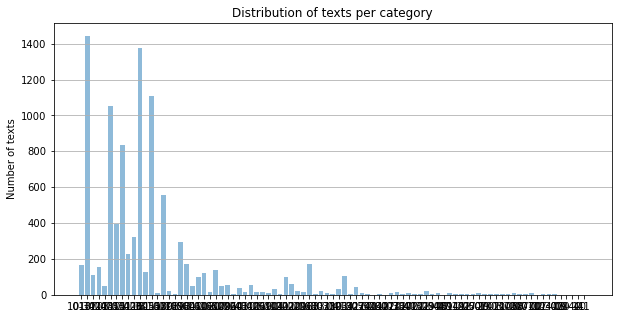

Counter({'01-40': 1443, '18': 1378, '01-60': 1109, '03-50': 1054, '11-40': 833, '15-10': 555, '13-30': 395, '11-30': 324, '08-60': 295, '05-20': 229, '09-30': 173, '19-10': 171, '10-30': 167, '07-40': 155, '06-20': 139, '16-10': 126, '11-60': 123, '13-20': 110, '19-30': 103, '04-10': 99, '04-20': 97, '10-20': 62, '03-20': 56, '07-20': 52, '11-70': 51, '03-60': 51, '20-20': 48, '14-50': 46, '06-30': 40, '19-20': 34, '13-10': 34, '13-60': 22, '12-10': 22, '03-30': 20, '07-30': 20, '14-40': 18, '12-60': 16, '01-50': 15, '11-50': 15, '02-30': 15, '01-10': 14, '03-10': 10, '02-10': 10, '17-10': 10, '12-50': 9, '12-30': 9, '19-40': 9, '10-07': 9, '15-07': 8, '06-10': 8, '05-10': 8, '07-10': 8, '12-40': 7, '09-40': 6, '04': 6, '17-20': 6, '19': 6, '16-07': 5, '03-07': 5, '17-30': 5, '11-20': 5, '01-30': 5, '01-20': 4, '01-07': 4, '13-40': 4, '02-20': 4, '14-20': 4, '19-50': 4, '03': 4, '02-70': 4, '08-10': 3, '09-50': 2, '09-20': 2, '12-07': 2, '20-10': 2, '05-07': 2, '07-07': 2, '14-10': 2, 

In [7]:
categories = df[['Directory code']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [8]:
def calculate_stats(df, split_char=' '):
    categories = df['Directory code'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['Text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['Directory code']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)


    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['Directory code'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')


    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [9]:
#df_stats = calculate_stats(df)
#df_stats['per_category']

In [10]:
#display_lengths_histograms(df_stats)

In [11]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['Directory code'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 9941
Number of categories: 87
Done!


In [12]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1


    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [13]:
# Transform categories into numbers
category_to_id = {}


category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: '10-30',
 1: '01-40',
 2: '13-20',
 3: '07-40',
 4: '11-70',
 5: '03-50',
 6: '13-30',
 7: '11-40',
 8: '05-20',
 9: '11-30',
 10: '18',
 11: '16-10',
 12: '01-60',
 13: '15-07',
 14: '15-10',
 15: '13-60',
 16: '09-50',
 17: '08-60',
 18: '19-10',
 19: '03-60',
 20: '04-10',
 21: '11-60',
 22: '01-50',
 23: '06-20',
 24: '20-20',
 25: '07-20',
 26: '09-40',
 27: '06-30',
 28: '14-40',
 29: '03-20',
 30: '11-50',
 31: '01-10',
 32: '06-10',
 33: '19-20',
 34: '01-20',
 35: '04-20',
 36: '10-20',
 37: '12-10',
 38: '12-60',
 39: '09-30',
 40: '16-07',
 41: '03-30',
 42: '03-10',
 43: '04',
 44: '13-10',
 45: '19-30',
 46: '03-07',
 47: '14-50',
 48: '12-50',
 49: '17-20',
 50: '14-60',
 51: '01-07',
 52: '04-07',
 53: '12-30',
 54: '02-30',
 55: '13-40',
 56: '02-10',
 57: '17-30',
 58: '02-20',
 59: '07-30',
 60: '12-40',
 61: '19-40',
 62: '07',
 63: '05-10',
 64: '09-20',
 65: '14-20',
 66: '19-50',
 67: '12-07',
 68: '17-10',
 69: '19',
 70: '20-10',
 71: '03',
 72: '02-70',
 73

In [14]:
# I have ndarray values and I want them to become int
y_data = y_data.astype(int)

In [15]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [16]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [17]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)


        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [18]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [19]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=5,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/5
870/870 [==============================] - 322s 355ms/step - loss: 1.0181 - accuracy: 0.7644 - val_loss: 0.5593 - val_accuracy: 0.8683
Epoch 2/5
870/870 [==============================] - 262s 301ms/step - loss: 0.3049 - accuracy: 0.9175 - val_loss: 0.5655 - val_accuracy: 0.8756
Epoch 3/5
870/870 [==============================] - 261s 300ms/step - loss: 0.0866 - accuracy: 0.9759 - val_loss: 0.5454 - val_accuracy: 0.8763
Epoch 4/5
870/870 [==============================] - 261s 300ms/step - loss: 0.0502 - accuracy: 0.9905 - val_loss: 0.5633 - val_accuracy: 0.8793
Epoch 5/5
870/870 [==============================] - 260s 299ms/step - loss: 0.0514 - accuracy: 0.9899 - val_loss: 0.5344 - val_accuracy: 0.8974


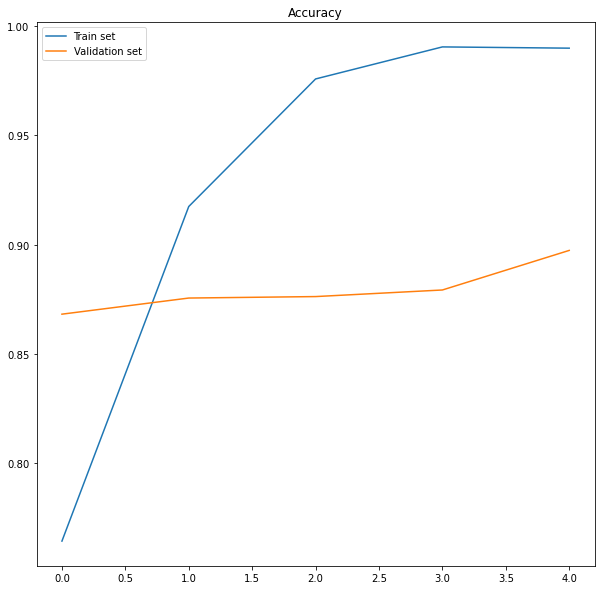

In [20]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [21]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 89.71%
94/94 [==============================] - 27s 283ms/step


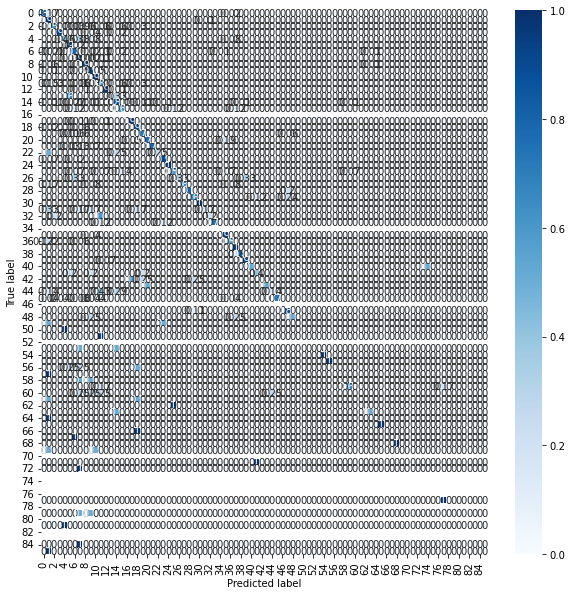

In [22]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))
plot_confusion_matrix(X_test, y_test, model)

In [23]:
# import new_text.csv and do predictions
df_test_test = pd.read_csv('new_test.csv')



In [24]:
X_test_test = df_test_test[['Text']].to_numpy().reshape(-1)
X_test_test = roberta_encode(X_test_test, tokenizer)

y_pred = model.predict(X_test_test)


78/78 [==============================] - 23s 291ms/step


In [25]:
y_pred = [np.argmax(i) for i in model.predict(X_test_test)]

78/78 [==============================] - 22s 285ms/step


In [26]:
# I want to convert y_pred using the category_to_id
y_pred_new = [category_to_name[i] for i in y_pred]

In [27]:
# convert y_pred_new to dataset from list
y_pred_new_df = pd.DataFrame()
y_pred_new_df['label'] = y_pred_new

# rename 

# to csv
y_pred_new_df.to_csv('output_bert.csv', index=False)


